In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [56]:
df = pd.read_csv("C:\\Users\\vishn\\Downloads\\extracted_data.csv")
df.head()

,time,HGT_prl,latitude,longitude,TMP_prl,TMP_2m,APCP_sfc,UGRD_10m,VGRD_10m
0,1990-01-01 00:00:00,5851.0586,13.68,80.16,289.79260,298.78370,1.409983e-14,-0.730697,0.115279
1,1990-01-01 06:00:00,5856.1550,13.68,80.16,288.84174,298.66785,2.255973e-13,-3.830207,-1.373627
2,1990-01-01 12:00:00,5853.1550,13.68,80.16,289.89853,299.04560,0.000000e+00,-4.528024,-1.926858
3,1990-01-01 18:00:00,5848.7900,13.68,80.16,288.81348,298.87085,0.000000e+00,-4.498979,-0.072557
4,1990-01-02 00:00:00,5851.9550,13.68,80.16,288.18890,299.14282,6.250000e-02,-2.182430,-1.781631


In [57]:
df['time'] = pd.to_datetime(df['time'])
# Extract date-related features
df['date'] = df['time'].dt.date
df['time'] = df['time'].dt.time

In [58]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['time'].apply(lambda x: x.hour)

In [59]:
# Now you should be able to extract year, month, etc.
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['date'] = df['date'].dt.date

In [30]:
scaling_factor = 10**3  # Convert meters to millimeters
df['APCP_sfc'] = (df['APCP_sfc'] * scaling_factor).round().astype(int)

In [31]:
import pandas as pd

# Define a function to map months to seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Rainfall'
    else:
        return 'Unknown'  # Handles unexpected values, though should not be needed

# Assuming 'df' is your DataFrame with a 'date' column
# Convert the 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Extract the month from the 'date' column
df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(assign_season)

# Drop any existing season dummy variables to avoid duplication
df = df.drop(columns=[col for col in df.columns if col.startswith('season_')], errors='ignore')

# One-hot encode the seasons without dropping any category
df = pd.get_dummies(df, columns=['season'])

# Optional: Drop the 'month' column if it's not needed
df = df.drop(columns=['month'])

# Display the updated DataFrame


In [32]:
df.head()

,time,HGT_prl,latitude,longitude,TMP_prl,TMP_2m,APCP_sfc,UGRD_10m,VGRD_10m,date,hour,year,day_of_week,day_of_year,season_Rainfall,season_Spring,season_Summer,season_Winter
0,00:00:00,5851.0586,13.68,80.16,289.79260,298.78370,0,-0.730697,0.115279,1990-01-01,0,1990,0,1,0,0,0,1
1,06:00:00,5856.1550,13.68,80.16,288.84174,298.66785,0,-3.830207,-1.373627,1990-01-01,6,1990,0,1,0,0,0,1
2,12:00:00,5853.1550,13.68,80.16,289.89853,299.04560,0,-4.528024,-1.926858,1990-01-01,12,1990,0,1,0,0,0,1
3,18:00:00,5848.7900,13.68,80.16,288.81348,298.87085,0,-4.498979,-0.072557,1990-01-01,18,1990,0,1,0,0,0,1
4,00:00:00,5851.9550,13.68,80.16,288.18890,299.14282,62,-2.182430,-1.781631,1990-01-02,0,1990,1,2,0,0,0,1


In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
import pandas as pd
from tensorflow.keras.optimizers import RMSprop

# Assuming the dataset is loaded as 'df' and the target variable is 'UGRD_10m' (wind component u)

# Select features (X) and target variable (y)
# Using pressure, temperature, precipitation, wind direction (VGRD_10m), wind speed, and wind direction
features = df[['HGT_prl', 'APCP_sfc', 'TMP_2m', 'VGRD_10m', 'UGRD_10m','season_Rainfall', 'season_Spring', 'season_Summer', 'season_Winter']].values
target = df['UGRD_10m'].values
# Convert the 'date' column to DateTime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)



In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Normalize the data
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1)).ravel()

# Prepare data for GRU/LSTM with 2-day prediction horizon based on 7-day sequence
def create_sequences(data, target, seq_length, prediction_horizon):
    xs, ys = [], []
    for i in range(len(data) - seq_length - prediction_horizon + 1):
        x = data[i:i + seq_length]
        y = target[i + seq_length : i + seq_length + prediction_horizon]  # Predict next 2 days
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


SEQ_LENGTH = 28  # 7 days
PREDICTION_HORIZON = 8  # Predict the next 2 days
X, y = create_sequences(features_scaled, target_scaled, SEQ_LENGTH, PREDICTION_HORIZON)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build and train GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(GRU(50))
    model.add(Dense(PREDICTION_HORIZON))
    optimizer = RMSprop(learning_rate=0.001)  # Output layer with 2 neurons (for 2-day prediction)
    model.compile(optimizer= optimizer, loss='mae')
    return model

# Build and train LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(PREDICTION_HORIZON))
    optimizer = RMSprop(learning_rate=0.001)  # Output layer with 2 neurons (for 2-day prediction)
    model.compile(optimizer= optimizer, loss='mae')
    return model

# Create models
input_shape = (SEQ_LENGTH, 9)  # SEQ_LENGTH x number of features

gru_model = build_gru_model(input_shape)
lstm_model = build_lstm_model(input_shape)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1, callbacks=[lr_reduction])

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1, callbacks=[lr_reduction])

Epoch 1/20
1019/1019 [==============================] - 16s 13ms/step - loss: 0.0662 - val_loss: 0.0593 - lr: 0.0010
Epoch 2/20
1019/1019 [==============================] - 13s 13ms/step - loss: 0.0435 - val_loss: 0.0417 - lr: 0.0010
Epoch 3/20
1019/1019 [==============================] - 13s 13ms/step - loss: 0.0404 - val_loss: 0.0394 - lr: 0.0010
Epoch 4/20
1019/1019 [==============================] - 15s 15ms/step - loss: 0.0382 - val_loss: 0.0387 - lr: 0.0010
Epoch 5/20
1019/1019 [==============================] - 16s 15ms/step - loss: 0.0368 - val_loss: 0.0382 - lr: 0.0010
Epoch 6/20
1019/1019 [==============================] - 15s 15ms/step - loss: 0.0365 - val_loss: 0.0391 - lr: 0.0010
Epoch 7/20
1019/1019 [==============================] - 15s 15ms/step - loss: 0.0362 - val_loss: 0.0377 - lr: 0.0010
Epoch 8/20
1019/1019 [==============================] - 14s 14ms/step - loss: 0.0361 - val_loss: 0.0369 - lr: 0.0010
Epoch 9/20
1019/1019 [==============================] - 14s 14ms

In [36]:
gru_loss = gru_model.evaluate(X_test, y_test)
lstm_loss = lstm_model.evaluate(X_test, y_test)

# Calculate R-squared value
gru_predictions = gru_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

gru_r2 = r2_score(y_test, gru_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print(f'GRU Test loss: {gru_loss}, R-squared: {gru_r2}')
print(f'LSTM Test loss: {lstm_loss}, R-squared: {lstm_r2}')

283/283 [==============================] - 2s 4ms/step
GRU Test loss: 0.03438977897167206, R-squared: 0.6738553580779878
LSTM Test loss: 0.035392601042985916, R-squared: 0.6703685816353353


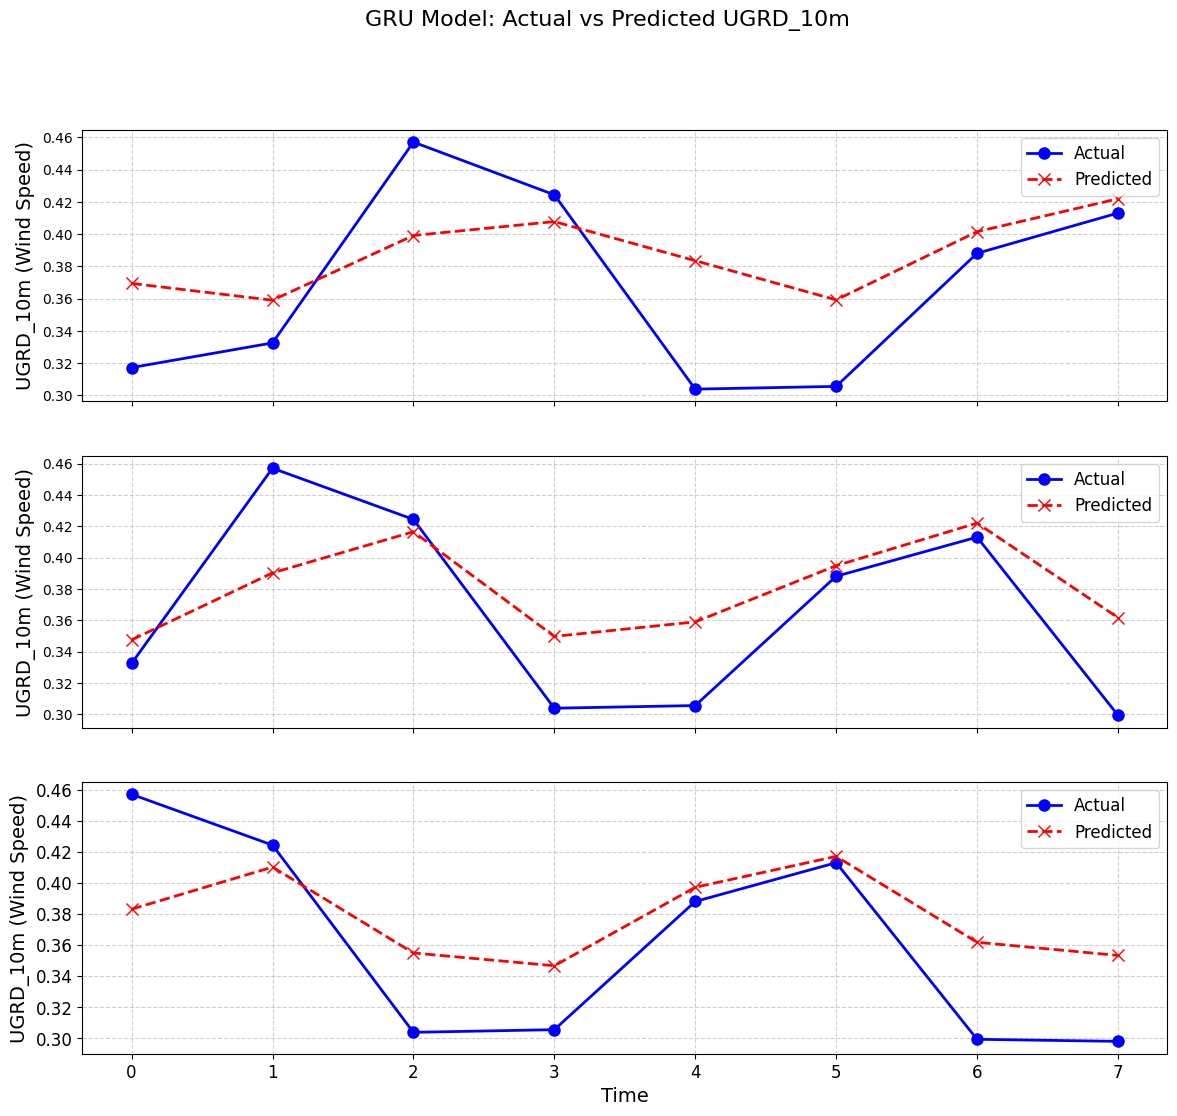

In [63]:
import matplotlib.pyplot as plt

# Example dimensions (replace these with your actual data)
# num_sequences = 3  # Number of sequences
# sequence_length = 10  # Maximum length of the sequence

fig, axs = plt.subplots(num_sequences, 1, figsize=(14, 4 * num_sequences), sharex=True)

for i in range(num_sequences):
    # Get the minimum length among time, y_test, and gru_predictions for each sequence
    min_length = min(len(time[:sequence_length]), len(y_test[i, :sequence_length]), len(gru_predictions[i, :sequence_length]))

    # Plotting only up to the minimum length
    axs[i].plot(time[:min_length], y_test[i, :min_length], label='Actual', marker='o', linestyle='-', color='blue', markersize=8, linewidth=2)
    axs[i].plot(time[:min_length], gru_predictions[i, :min_length], label='Predicted', marker='x', linestyle='--', color='red', markersize=8, linewidth=2)
    
    axs[i].set_ylabel('UGRD_10m (Wind Speed)', fontsize=14)
    axs[i].legend(fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[-1].set_xlabel('Time', fontsize=14)
fig.suptitle('GRU Model: Actual vs Predicted UGRD_10m', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


283/283 [==============================] - 1s 5ms/step


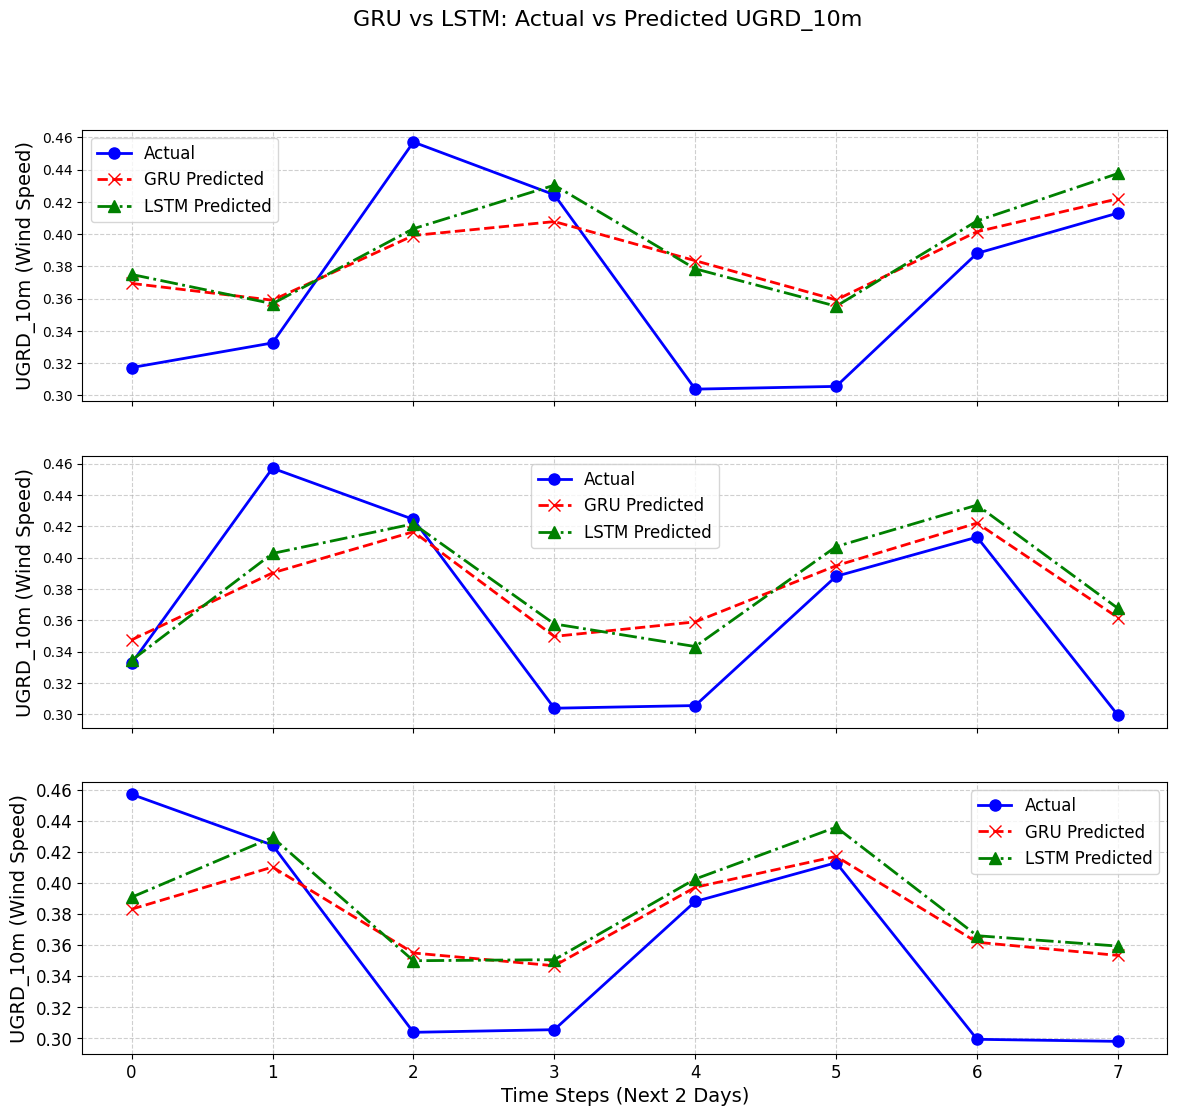

In [64]:
import matplotlib.pyplot as plt

# Assuming you have predictions from both models
gru_predictions = gru_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

# Plotting first few sequences to compare actual vs predicted
num_sequences = 3  # Number of sequences to plot
sequence_length = PREDICTION_HORIZON  # Prediction horizon (2 days)

fig, axs = plt.subplots(num_sequences, 1, figsize=(14, 4 * num_sequences), sharex=True)

for i in range(num_sequences):
    # Plot Actual values
    axs[i].plot(range(sequence_length), y_test[i, :sequence_length], label='Actual', marker='o', linestyle='-', color='blue', markersize=8, linewidth=2)
    
    # Plot GRU predictions
    axs[i].plot(range(sequence_length), gru_predictions[i, :sequence_length], label='GRU Predicted', marker='x', linestyle='--', color='red', markersize=8, linewidth=2)
    
    # Plot LSTM predictions
    axs[i].plot(range(sequence_length), lstm_predictions[i, :sequence_length], label='LSTM Predicted', marker='^', linestyle='-.', color='green', markersize=8, linewidth=2)
    
    axs[i].set_ylabel('UGRD_10m (Wind Speed)', fontsize=14)
    axs[i].legend(fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[-1].set_xlabel('Time Steps (Next 2 Days)', fontsize=14)
fig.suptitle('GRU vs LSTM: Actual vs Predicted UGRD_10m', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


283/283 [==============================] - 1s 4ms/step


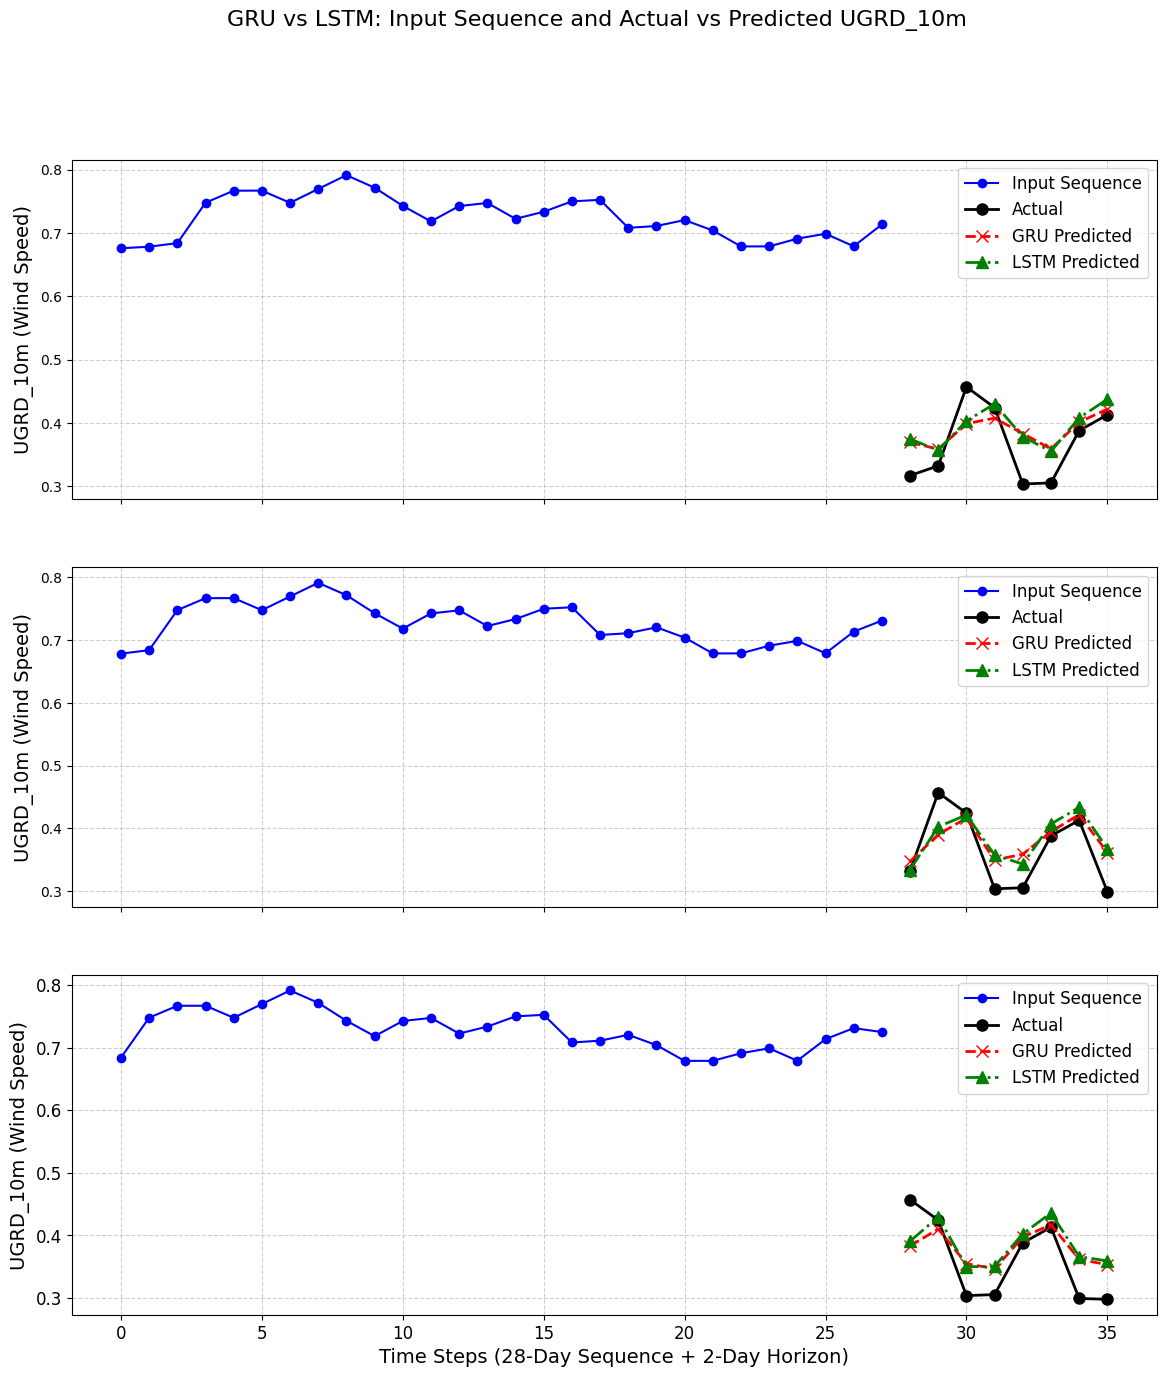

In [65]:
import matplotlib.pyplot as plt

# Get predictions from GRU and LSTM models
gru_predictions = gru_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

# Number of sequences to plot
num_sequences = 3  # Number of sequences you want to plot

# Total length to display (input sequence + prediction horizon)
total_length = SEQ_LENGTH + PREDICTION_HORIZON

fig, axs = plt.subplots(num_sequences, 1, figsize=(14, 5 * num_sequences), sharex=True)

for i in range(num_sequences):
    # Plot the input sequence
    axs[i].plot(range(SEQ_LENGTH), X_test[i, :, 0], label='Input Sequence', marker='o', linestyle='-', color='blue', markersize=6, linewidth=1.5)
    
    # Plot the actual values for the prediction horizon
    axs[i].plot(range(SEQ_LENGTH, total_length), y_test[i, :PREDICTION_HORIZON], label='Actual', marker='o', linestyle='-', color='black', markersize=8, linewidth=2)
    
    # Plot the GRU model predictions
    axs[i].plot(range(SEQ_LENGTH, total_length), gru_predictions[i, :PREDICTION_HORIZON], label='GRU Predicted', marker='x', linestyle='--', color='red', markersize=8, linewidth=2)
    
    # Plot the LSTM model predictions
    axs[i].plot(range(SEQ_LENGTH, total_length), lstm_predictions[i, :PREDICTION_HORIZON], label='LSTM Predicted', marker='^', linestyle='-.', color='green', markersize=8, linewidth=2)
    
    axs[i].set_ylabel('UGRD_10m (Wind Speed)', fontsize=14)
    axs[i].legend(fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[-1].set_xlabel('Time Steps (28-Day Sequence + 2-Day Horizon)', fontsize=14)
fig.suptitle('GRU vs LSTM: Input Sequence and Actual vs Predicted UGRD_10m', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()
